## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
Каждое задание весит 1 балл, если выполнено полностью и без ошибок, 0 баллов ставится при наличии хотя бы 1 ошибки. Максимальная оценка - 10 баллов. Шаблоны функций и классов можно менять по своему усмотрению. Сдать задание надо на edu.tinkoff. По вопросам пишите, как всегда сюда)


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [3]:
!wget https://storage.yandexcloud.net/datasouls-ods/materials/7952fa0d/recsys_course.zip

--2025-02-11 19:14:57--  https://storage.yandexcloud.net/datasouls-ods/materials/7952fa0d/recsys_course.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79057125 (75M) [application/zip]
Saving to: ‘recsys_course.zip’

recsys_course.zip   100%[===================>]  75.39M  14.9MB/s    in 6.2s    

2025-02-11 19:15:04 (12.2 MB/s) - ‘recsys_course.zip’ saved [79057125/79057125]



In [4]:
!unzip recsys_course.zip

Archive:  recsys_course.zip
  inflating: items.csv               
  inflating: RecSys notebook Baseline.ipynb  
  inflating: RecSys notebook EDA.ipynb  
  inflating: sample_submission.csv   
  inflating: users.csv               
  inflating: interactions.csv        


In [5]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
5366810,44603,15297,126,24477,100.0
2064300,37214,2100,83,4228,77.0
5002149,1038221,7033,153,8352,100.0
1308685,929926,14703,7,7180,100.0
5323974,106760,13589,58,8,0.0


Сделаем разбиение по времени

<Axes: >

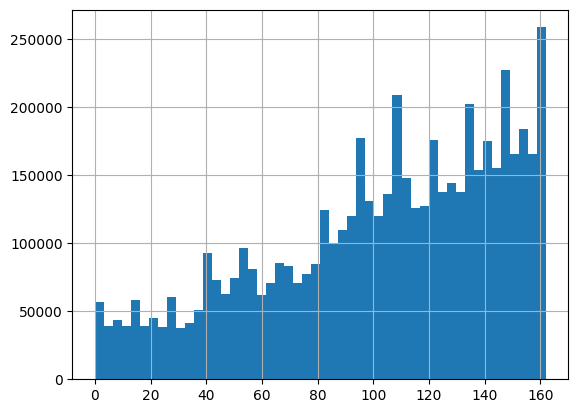

In [7]:
df.last_watch_dt.hist(bins=50)

In [8]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [9]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [10]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [11]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
236,1074210,15930,129,103,4.0
260,779186,12501,16,4995,96.0
270,239600,11640,127,40991,50.0
329,1045343,13218,78,331,7.0
333,384509,1048,77,1027,16.0


In [12]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-12-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-12-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,109,"[(11047, 146)]"
1,130,"[(6431, 147)]"
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,..."
3,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863..."


In [13]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]"
1,130,"[(6431, 147)]","[(5434, 159)]"
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]"
3,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]"


In [14]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[8480, 2319, 9861]"
1,130,"[(6431, 147)]","[(5434, 159)]","[8480, 2319, 9861]"
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]","[8480, 2319, 9861]"
3,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[8480, 2319, 9861]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8480, 2319, 9861]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [47]:
import numpy as np
from typing import List, Optional

def ap_metric(gt_items, predictions, topn=None):
    if not gt_items or len(gt_items) == 0:
        return 0.0  # Если нет известных взаимодействий, AP = 0

    gt_set = set(gt_items)
    if topn is None:
        topn = len(predictions)

    relevant = [1 if pred in gt_set else 0 for pred in predictions[:topn]]

    if sum(relevant) == 0:  # Если среди top-K нет релевантных айтемов
        return 0.0

    precisions = [sum(relevant[:i + 1]) / (i + 1) for i in range(len(relevant))]
    ap = sum(p * r for p, r in zip(precisions, relevant)) / min(len(gt_set), topn)

    return ap


def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    predictions = predictions[:topn]
    gt_set = set(gt_items)

    for idx, pred in enumerate(predictions):
        if pred in gt_set:
            return 1.0 / (idx + 1)

    return 0.0


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    predictions = predictions[:topn]
    gt_set = set(gt_items)

    return int(any(pred in gt_set for pred in predictions))

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [16]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [17]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):
    metric_values = []

    # Подготовка данных
    gt_items_list = df[gt_col].apply(lambda x: {item[0] for item in x}).values
    predictions_list = df[model_preds].values

    # Векторизованная обработка
    for gt_items, predictions in zip(gt_items_list, predictions_list):
        ap = ap_metric(list(gt_items), predictions)
        rr = rr_metric(list(gt_items), predictions)
        hr = hr_metric(list(gt_items), predictions)

        metric_values.append((ap, rr, hr))

    return {
        'map': np.mean([x[0] for x in metric_values]),
        'mrr': np.mean([x[1] for x in metric_values]),
        'hr': np.mean([x[2] for x in metric_values])
    }

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [18]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0, 'mrr': 0.0, 'hr': 0.0}

In [19]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommendations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommendations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
1,130,"[(6431, 147)]","[(5434, 159)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
3,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [20]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06730781459435625, 'mrr': 0.11963369047619046, 'hr': 0.2712}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [21]:
from tqdm import tqdm

import matplotlib.pyplot as plt

In [22]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        max_time = max(df[col].apply(lambda x: max(y[1] for y in x)))

        for _, row in df.iterrows():
            for item, timestamp in row[col]:
                if timestamp >= (max_time - self.min_window):  # Убрали лишний вызов max()
                    counts[item] = counts.get(item, 0) + 1  # Оптимизированное обновление словаря

        self.recommendations = sorted(counts, key=counts.get, reverse=True)
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

In [23]:
# Определение значений окна
window_sizes = [2, 5, 10, 20, 50, 75, 100]

# Словари для хранения результатов
metrics_results = {"map": [], "mrr": [], "hr": []}

In [24]:
# Запуск экспериментов для различных размеров окна
for window in tqdm(window_sizes):
    model = TopPopularWeighted(min_window=window)
    model.fit(joined)
    joined["toppop_weighted_recs"] = model.predict(joined)
    metrics = evaluate_recommender(joined, model_preds="toppop_weighted_recs")

    # Запись метрик
    metrics_results["map"].append(metrics["map"])
    metrics_results["mrr"].append(metrics["mrr"])
    metrics_results["hr"].append(metrics["hr"])

100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


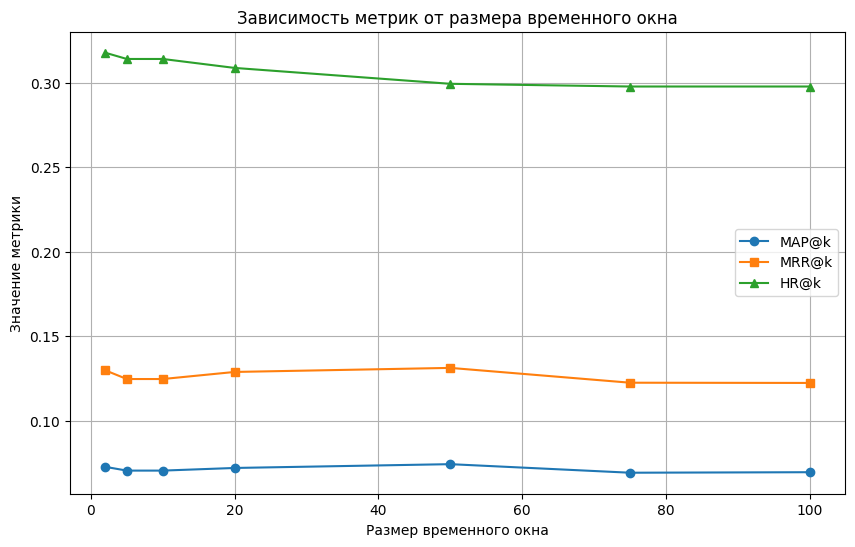

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, metrics_results["map"], marker="o", label="MAP@k")
plt.plot(window_sizes, metrics_results["mrr"], marker="s", label="MRR@k")
plt.plot(window_sizes, metrics_results["hr"], marker="^", label="HR@k")
plt.xlabel("Размер временного окна")
plt.ylabel("Значение метрики")
plt.title("Зависимость метрик от размера временного окна")
plt.legend()
plt.grid(True)
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

1. **Как размер окна влияет на качество рекомендаций?**
   - При увеличении размера окна (например, окна до 20) качество рекомендаций (особенно HR@k) увеличивается
   - Однако при дальнейшем увеличении окна качество начинает уменьшаться, особенно для HR@k. Это происходит из-за того, что старые популярные элементы начинают «замещать» более актуальные, которые чаще встречаются в меньших окнах

2. **Какое значение наилучшее?**
   - По графику видно, что оптимальное окно — до 10–20. Это значение обеспечивает баланс между учётом актуальных предпочтений пользователей и достаточным количеством данных для определения популярности

3. **Есть ли разумное объяснение?**
   - Маленькое окно отражает только актуальные предпочтения, но недостаточно данных для формирования качественных рекомендаций
   - Слишком большое окно захватывает устаревшие данные, которые уже не соответствуют текущим предпочтениям пользователей
   - Значение 10–20 позволяет учесть наиболее свежие предпочтения, сохраняя достаточный объём данных для качественного ранжирования


**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [26]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [27]:
k_values = range(1, 101)

# Словари для хранения метрик
metrics_results_k = {"map": [], "mrr": [], "hr": []}

In [28]:
for k in tqdm(k_values):
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    metrics = evaluate_recommender(joined, model_preds='toppopular_recs',
                                   gt_col='test_interactions')
    metrics_results_k["map"].append(metrics["map"])
    metrics_results_k["mrr"].append(metrics["mrr"])
    metrics_results_k["hr"].append(metrics["hr"])

100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


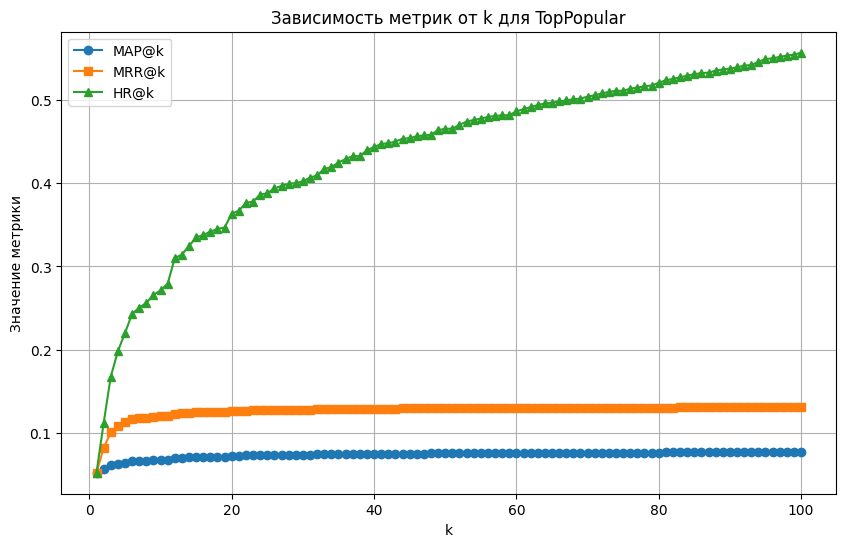

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, metrics_results_k["map"], marker="o", label="MAP@k")
plt.plot(k_values, metrics_results_k["mrr"], marker="s", label="MRR@k")
plt.plot(k_values, metrics_results_k["hr"], marker="^", label="HR@k")
plt.xlabel("k")
plt.ylabel("Значение метрики")
plt.title("Зависимость метрик от k для TopPopular")
plt.legend()
plt.grid(True)
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными?
- **HR@K (Hit Rate)** **MRR@K (Mean Reciprocal Rank)** являются строго монотонно неубывающей функцией по top-K. Это происходит потому, что с увеличением K вероятность наличия хотя бы одного релевантного элемента среди первых K рекомендаций только увеличивается
- **MAP@K (Mean Average Precision)** не является строго монотонными, так как зависит от ранжирования релевантных элементов. Если добавление новых элементов снижает ранжирование релевантных объектов, это может уменьшить значения метрик

3.2 Объясните по каждой метрике, как можно интерпретировать ее график?
- **MAP@K**: График показывает качество ранжирования в первых K рекомендациях. Если метрика остаётся почти постоянной, это может указывать на низкую точность ранжирования, даже при увеличении количества рекомендаций
- **MRR@K**: Показывает, насколько высоко находится первый релевантный элемент. Плоский график после определённого значения K указывает, что первый релевантный элемент стабильно появляется в первых нескольких рекомендациях
- **HR@K**: Указывает на вероятность того, что хотя бы один релевантный элемент будет в рекомендациях. Рост этой метрики с K указывает на лучшее покрытие релевантных объектов

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть?
- **HR@K** растёт, так как большее значение K увеличивает вероятность захвата хотя бы одного релевантного элемента
- **MRR@K** стабилизируется после определённого K, так как первый релевантный элемент уже найден в начале, и дальнейшее увеличение K не влияет
- **MAP@K** остаётся практически постоянной, если качество ранжирования не меняется. Это может быть связано с тем, что TopPopular не учитывает индивидуальные предпочтения пользователей, а только общее ранжирование.
- Общий вид графиков зависит от количества релевантных элементов, качества ранжирования и способа построения рекомендаций


**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [30]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

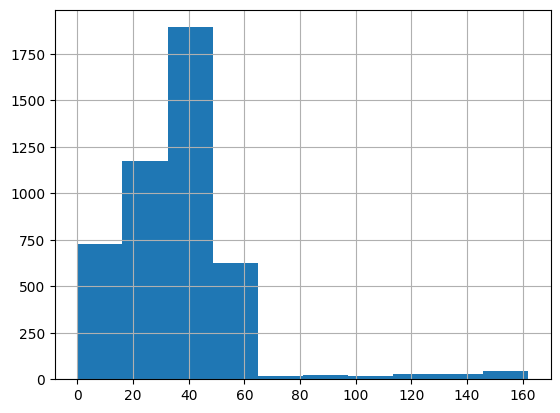

In [31]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

Фильм: 1917


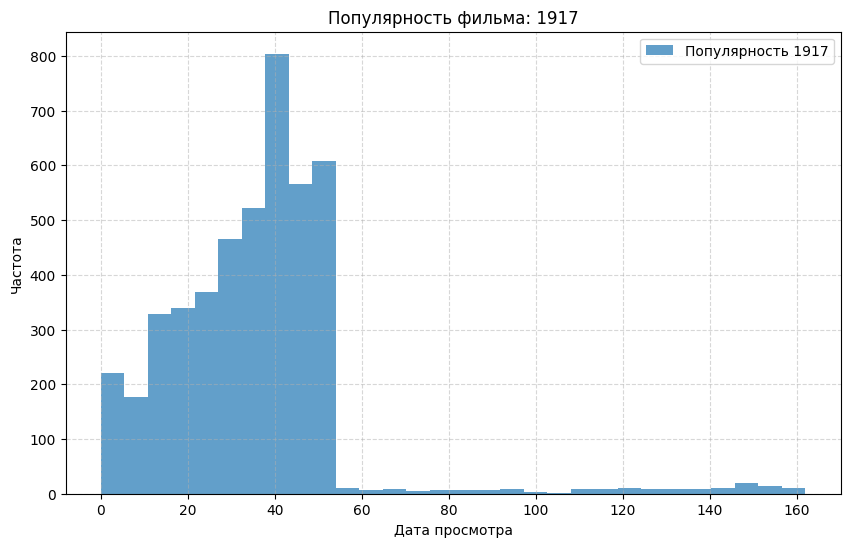

Фильм: Поговори с ней


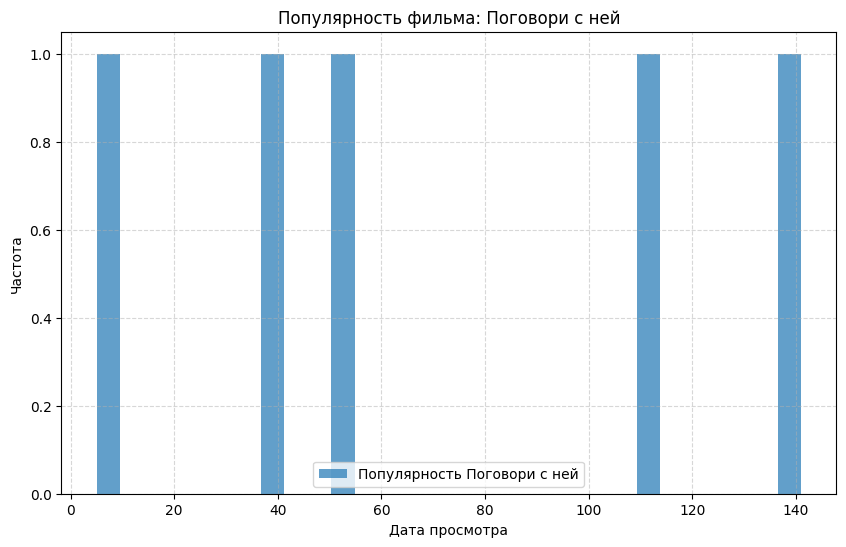

Фильм: 45 лет


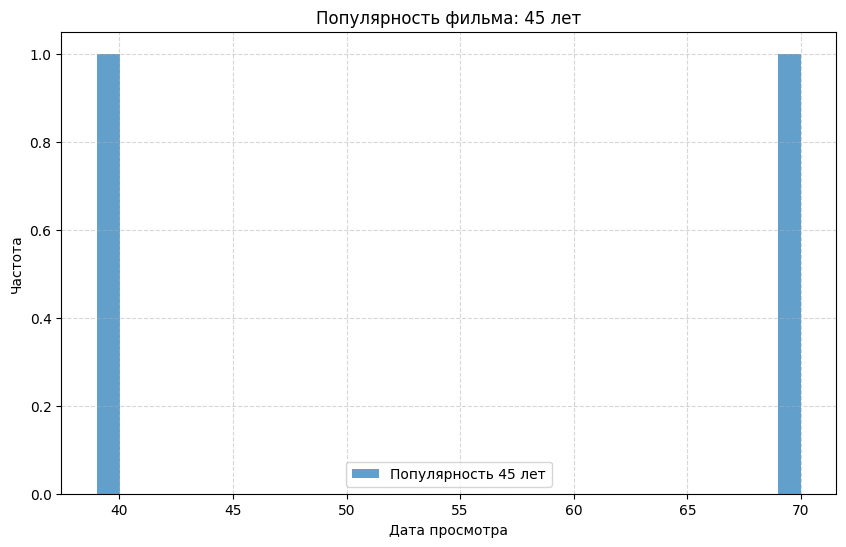

Фильм: Голые перцы


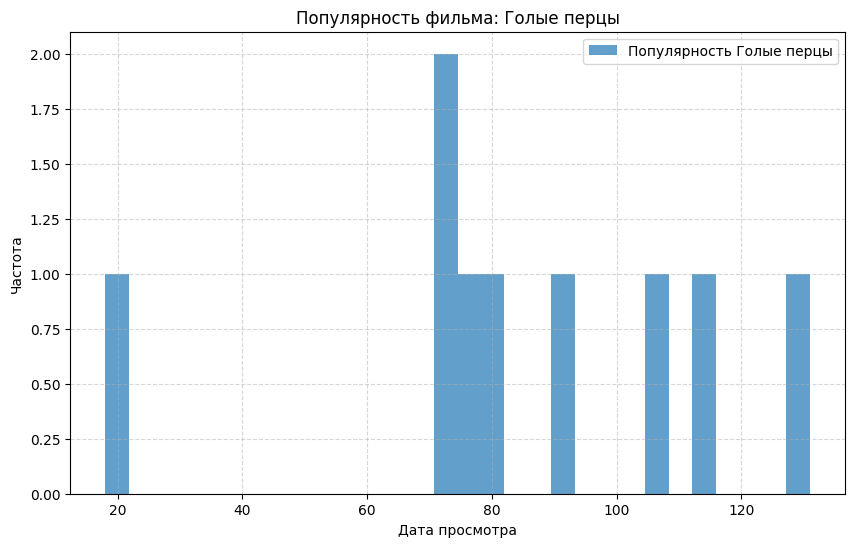

Фильм: Все решает мгновение


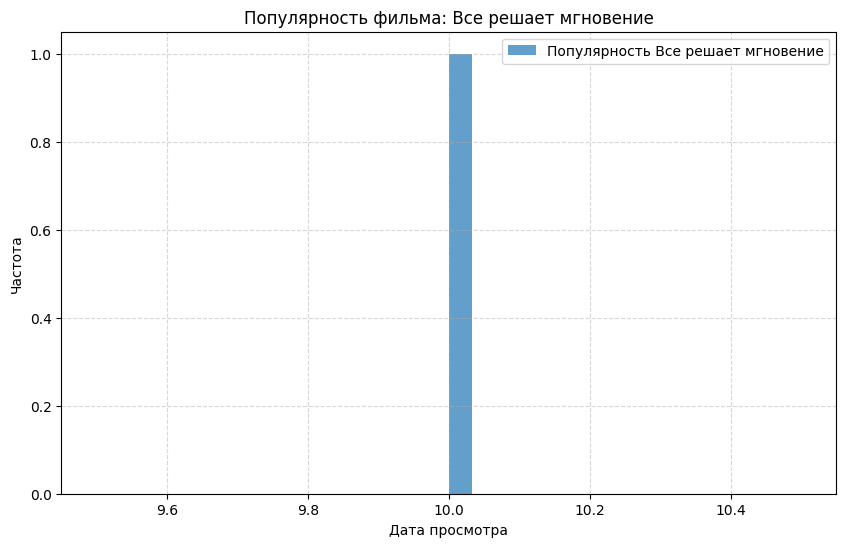

In [32]:
# Популярные фильмы
popular_items = df.item_id.value_counts()[:300].index.tolist()

# Функция для анализа популярности фильма
def analyze_item_popularity(item_id, df, items):
    interactions = df.loc[df.item_id == item_id].copy()
    name = items.loc[items.item_id == item_id].title.values[0]
    print(f"Фильм: {name}")

    # Построение графика популярности
    plt.figure(figsize=(10, 6))
    interactions.last_watch_dt.hist(bins=30, alpha=0.7, label=f"Популярность {name}")
    plt.xlabel("Дата просмотра")
    plt.ylabel("Частота")
    plt.title(f"Популярность фильма: {name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Пример анализа
sampled_ids = [3402, 10711, 7868, 2508, 16268]  # Взяли несколько популярных фильмов
for sampled_id in sampled_ids:
    analyze_item_popularity(sampled_id, df, items)

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [33]:
def filter_column(df, column, min_freq):
    """
    Фильтрует DataFrame, оставляя только значения в column, которые встречаются не менее min_freq раз
    """
    value_counts = df[column].value_counts()
    filtered_values = value_counts[value_counts >= min_freq].index
    return df[df[column].isin(filtered_values)]


def filter_dataframe(df, cols, min_freq=5):
    """
    Итеративно фильтрует DataFrame по столбцам, чтобы каждый из них удовлетворял условию min_freq
    """
    while True:
        initial_shape = df.shape
        for col in cols:
            df = filter_column(df, col, min_freq)
        if df.shape == initial_shape:
            break
    return df


# Фильтрация данных
filtered_train = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=5)

In [34]:
def df_encode(df):
    """
    Перекодирует идентификаторы пользователей и айтемов в уникальные последовательности чисел
    """
    item2id = {k: v for v, k in enumerate(df.item_id.unique())}
    user2id = {k: v for v, k in enumerate(df.user_id.unique())}

    id2item = {v: k for k, v in item2id.items()}
    id2user = {v: k for k, v in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])

    return df, user2id, item2id, id2user, id2item

In [35]:
# Кодирование данных
filtered_train, user2id, item2id, id2user, id2item = df_encode(filtered_train)

# Создание разреженной матрицы
from scipy import sparse as sps

In [36]:
matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<302205x10031 sparse matrix of type '<class 'numpy.float64'>'
	with 4278492 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

In [37]:
# Диапазон значений min_freq
min_freq_values = range(2, 21)

# Списки для хранения количества пользователей и айтемов
num_users = []
num_items = []

# Цикл по значениям min_freq
for min_freq in tqdm(min_freq_values):
    filtered_df = filter_dataframe(df, cols=["user_id", "item_id"], min_freq=min_freq)
    num_users.append(filtered_df["user_id"].nunique())
    num_items.append(filtered_df["item_id"].nunique())

100%|██████████| 19/19 [00:51<00:00,  2.70s/it]


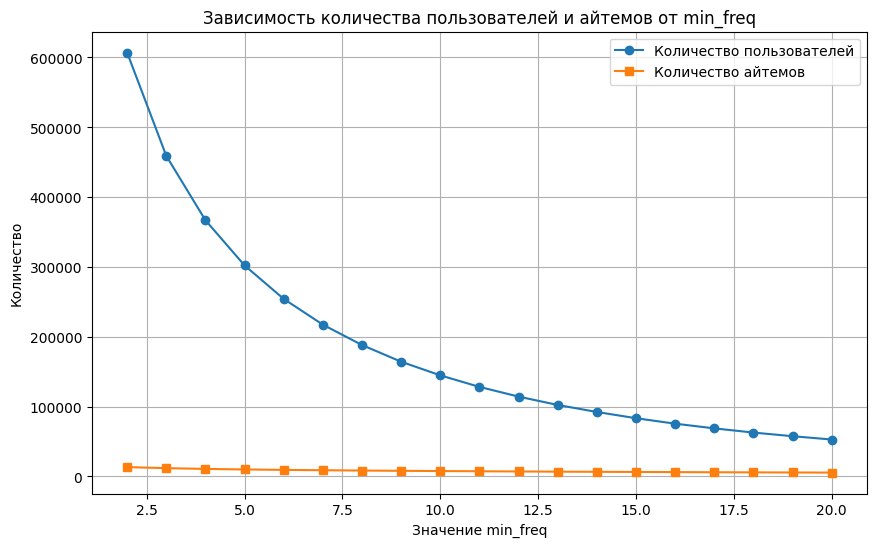

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(min_freq_values, num_users, label="Количество пользователей", marker="o")
plt.plot(min_freq_values, num_items, label="Количество айтемов", marker="s")
plt.xlabel("Значение min_freq")
plt.ylabel("Количество")
plt.title("Зависимость количества пользователей и айтемов от min_freq")
plt.legend()
plt.grid(True)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [39]:
import numpy as np
import scipy.sparse as sp
import joblib

def fit_ease(X, reg_weight=1000, save_path="ease_weights.pkl"):
    """
    Обучение EASE и сохранение матрицы весов на диск
    """
    X = sp.csr_matrix(X)
    G = X.T @ X  # Матрица item-item
    diag = np.diag(G.toarray())  # Извлекаем диагональ
    G.setdiag(diag + reg_weight)  # Добавляем регуляризацию

    # Инверсия только нужных элементов
    P = np.linalg.inv(G.toarray())  # Преобразуем в dense, чтобы не держать лишнее в памяти
    B = -P / np.diag(P)[:, None]  # Нормализация
    np.fill_diagonal(B, 0)  # Обнуление диагонали

    # Сохранение весов в файл
    joblib.dump(B, save_path)
    print(f"Матрица весов сохранена в {save_path}")

    return save_path, B

# Функция для предсказания рекомендаций
def predict_ease(X, weights_path, topn=10, batch_size=1000):
    """
    Генерация рекомендаций с загрузкой весов из файла и поблочной обработкой
    """
    X = sp.csr_matrix(X)
    B = joblib.load(weights_path)  # Загружаем матрицу весов

    num_users = X.shape[0]
    recs = np.zeros((num_users, topn), dtype=int)

    # Обрабатываем данные батчами, чтобы не вылететь по памяти
    for start in tqdm(range(0, num_users, batch_size)):
        end = min(start + batch_size, num_users)
        scores = X[start:end] @ B  # Вычисляем скоринг только для части пользователей
        recs[start:end] = np.argsort(-scores, axis=1)[:, :topn]  # Получаем топ-N

    return recs

In [40]:
# Обучение модели и сохранение весов
weights_path, w = fit_ease(matrix)

Матрица весов сохранена в ease_weights.pkl


In [41]:
# Получение рекомендаций
recommendations = predict_ease(matrix, weights_path, topn=10)
recommendations

100%|██████████| 303/303 [05:55<00:00,  1.17s/it]


array([[   0, 1292,  751, ...,  134, 2096,  414],
       [1292,    0,  887, ...,  414,  568,  639],
       [ 123,  147,  227, ...,  119,  943,  121],
       ...,
       [1337, 1872,  704, ...,  360, 2556, 1026],
       [ 202,  171,  656, ...,   12,  249,  309],
       [ 424,  264,  337, ...,   12,  194,  187]])

In [42]:
joblib.dump(recommendations, 'recommendations.pkl')
print(f"Рекомендации в 'recommendations.pkl'")

Рекомендации в 'recommendations.pkl'


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [43]:
def get_preds(user_interactions, item2id, id2item, ease_weights, topn=10):
    """
    Получение предсказаний для одного пользователя на основе матрицы весов EASE.
    user_interactions - список интеракций пользователя
    item2id - маппинг item_id -> индекс
    id2item - маппинг индекс -> item_id
    ease_weights - матрица весов модели EASE
    topn - количество топ предсказаний
    """
    # Построение вектора взаимодействий пользователя
    user_vector = np.zeros(len(item2id))
    for item_id, _ in user_interactions:
        if item_id in item2id:
            user_vector[item2id[item_id]] = 1

    # Получение предсказаний
    scores = user_vector @ ease_weights
    recommended_indices = np.argsort(-scores)[:topn]  # Топ-n предсказаний
    decoded = [id2item[idx] for idx in recommended_indices if user_vector[idx] == 0]  # Исключаем уже просмотренные

    return decoded

In [44]:
# Применение функции для каждого пользователя
joined['ease_preds'] = joined.train_interactions.apply(
    lambda x: get_preds(x, item2id, id2item, w, topn=10)
)

joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppop_weighted_recs,ease_preds
0,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[12133, 11578, 13218, 12974, 12988, 4266, 8181..."
1,130,"[(6431, 147)]","[(5434, 159)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[4285, 3487, 7216, 3768, 14646, 12396, 4008, 1..."
2,282,"[(5250, 45), (7626, 83), (12463, 106), (11348,...","[(12841, 162), (8821, 162)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[12173, 12057, 1553, 682, 14264, 7210, 12623, ..."
3,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[12995, 9728, 8251, 1449, 7107, 7417, 13763, 1..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8480, 2319, 9861]","[10440, 15297, 9728, 13865, 4151, 3734, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 2657, ...","[4151, 16228, 2657, 13865, 11640, 9996, 11778,..."


In [48]:
results = {}

# Оценка случайных рекомендаций
results["Random"] = evaluate_recommender(joined, model_preds="random_recs")

# Оценка TopPopular
results["TopPopular"] = evaluate_recommender(joined, model_preds="toppopular_recs")

# Оценка TopPopularWeighted (если использовался)
results["TopPopularWeighted"] = evaluate_recommender(joined, model_preds="toppop_weighted_recs")

# Оценка EASE
results["EASE"] = evaluate_recommender(joined, model_preds="ease_preds")

In [51]:
df_results = pd.DataFrame(results).T
df_results

,map,mrr,hr
Random,0.000000,0.000000,0.0000
TopPopular,0.076802,0.130746,0.5570
TopPopularWeighted,0.069527,0.122357,0.2978
EASE,0.057800,0.108274,0.2478


Сделайте выводы — какой алгоритм работает лучше?

1. **Лучший алгоритм — TopPopular** (лучшие MAP, MRR, HR)
2. **EASE работает хуже**, возможно, нужна другая регуляризация
3. **TopPopularWeighted хуже TopPopular** — окно не дало прироста
4. **Random провалился (все 0)**

EASE стоит тюнить, TopPopular — лучший базовый метод

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Логарифмическая сетка значений регуляризации
reg_values = np.logspace(1, 5, num=20)  # 20 значений от 10^1 до 10^5

# Словари для хранения метрик
metrics_results_reg = {"map": [], "mrr": [], "hr": []}

In [ ]:
# Тюнинг регуляризации
for reg in tqdm(reg_values):
    weights_path, w = fit_ease(matrix, reg_weight=reg, save_path=f"ease_weights_{int(reg)}.pkl")
    recommendations = predict_ease(matrix, weights_path, topn=10)

    # Ограничиваем количество предсказаний до числа пользователей в joined
    recommendations = recommendations[:len(joined)]

    # Добавление рекомендаций в DataFrame
    joined = joined.iloc[:len(recommendations)].copy()  # Обновляем индекс DataFrame
    joined['ease_preds'] = list(recommendations)

    # Оценка качества
    metrics = evaluate_recommender(joined, model_preds="ease_preds")

    # Запись результатов
    metrics_results_reg["map"].append(metrics["map"])
    metrics_results_reg["mrr"].append(metrics["mrr"])
    metrics_results_reg["hr"].append(metrics["hr"])

  0%|          | 0/20 [00:00<?, ?it/s]

Матрица весов сохранена в ease_weights_10.pkl



  5%|▌         | 1/20 [07:51<2:29:14, 471.27s/it]

Матрица весов сохранена в ease_weights_16.pkl



 10%|█         | 2/20 [15:36<2:20:18, 467.70s/it]

Матрица весов сохранена в ease_weights_26.pkl



 15%|█▌        | 3/20 [23:34<2:13:53, 472.57s/it]

Матрица весов сохранена в ease_weights_42.pkl



 20%|██        | 4/20 [31:30<2:06:22, 473.91s/it]

Матрица весов сохранена в ease_weights_69.pkl



 25%|██▌       | 5/20 [39:32<1:59:11, 476.79s/it]

Матрица весов сохранена в ease_weights_112.pkl



 30%|███       | 6/20 [47:51<1:53:00, 484.32s/it]

Матрица весов сохранена в ease_weights_183.pkl



 35%|███▌      | 7/20 [55:51<1:44:36, 482.79s/it]

Матрица весов сохранена в ease_weights_297.pkl



 40%|████      | 8/20 [1:03:54<1:36:33, 482.82s/it]

Матрица весов сохранена в ease_weights_483.pkl



 45%|████▌     | 9/20 [1:12:22<1:30:00, 490.92s/it]

Матрица весов сохранена в ease_weights_784.pkl



 50%|█████     | 10/20 [1:20:28<1:21:31, 489.17s/it]

Матрица весов сохранена в ease_weights_1274.pkl



 55%|█████▌    | 11/20 [1:28:34<1:13:14, 488.25s/it]

Матрица весов сохранена в ease_weights_2069.pkl



 60%|██████    | 12/20 [1:36:36<1:04:50, 486.37s/it]

Матрица весов сохранена в ease_weights_3359.pkl



 65%|██████▌   | 13/20 [1:44:29<56:16, 482.38s/it]  

Матрица весов сохранена в ease_weights_5455.pkl



 70%|███████   | 14/20 [1:52:23<47:59, 479.97s/it]

Матрица весов сохранена в ease_weights_8858.pkl



 75%|███████▌  | 15/20 [2:00:09<39:38, 475.70s/it]

Матрица весов сохранена в ease_weights_14384.pkl



 80%|████████  | 16/20 [2:08:06<31:43, 475.93s/it]

Матрица весов сохранена в ease_weights_23357.pkl



 85%|████████▌ | 17/20 [2:16:07<23:52, 477.44s/it]

Матрица весов сохранена в ease_weights_37926.pkl



 90%|█████████ | 18/20 [2:24:01<15:52, 476.39s/it]

Матрица весов сохранена в ease_weights_61584.pkl



 95%|█████████▌| 19/20 [2:31:54<07:55, 475.54s/it]

Матрица весов сохранена в ease_weights_100000.pkl



100%|██████████| 20/20 [2:39:40<00:00, 479.04s/it]


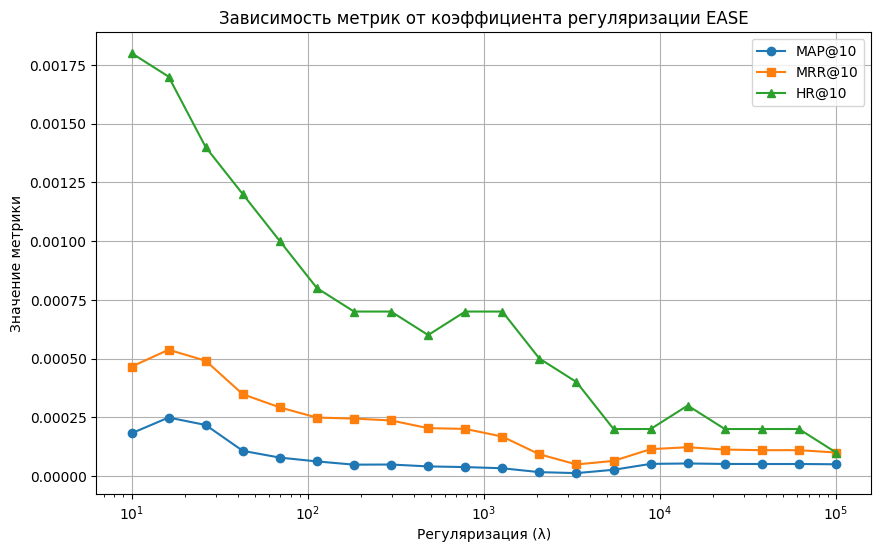

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(reg_values, metrics_results_reg["map"], marker="o", label="MAP@10")
plt.plot(reg_values, metrics_results_reg["mrr"], marker="s", label="MRR@10")
plt.plot(reg_values, metrics_results_reg["hr"], marker="^", label="HR@10")
plt.xscale("log")
plt.xlabel("Регуляризация (λ)")
plt.ylabel("Значение метрики")
plt.title("Зависимость метрик от коэффициента регуляризации EASE")
plt.legend()
plt.grid(True)
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


Лучшее значение регуляризации можно определить как такое, при котором метрики MAP@10, MRR@10 и HR@10 достигают своего максимума

Судя по графику, это происходит в диапазоне значений регуляризации около 10-20.
При дальнейшем увеличении λ метрики начинают снижаться, что указывает на переобучение модели


8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

- Метрика HR@10 показывает наиболее резкий спад с увеличением регуляризации, что говорит о том, что при сильной регуляризации модель теряет способность предсказывать релевантные айтемы
- MAP@10 и MRR@10 ведут себя более плавно, что указывает на их меньшую чувствительность к регуляризации
- На больших значениях λ метрики стабилизируются на низких уровнях, что ожидаемо, так как модель фактически становится слишком "сглаженной" и теряет информативность
- Влияние регуляризации на HR@10 сильнее, чем на MAP@10 и MRR@10, что может быть связано с тем, что HR@10 реагирует на наличие хотя бы одного релевантного предсказания, в то время как MAP и MRR оценивают порядок предсказаний

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

In [ ]:
# Определяем значения topK и пороги встречаемости user/item
topk_values = range(1, 101, 5)  # topK от 1 до 100 с шагом 5
min_freq_values = [2, 5, 10, 20]  # Минимальная частота встречаемости user/item

# Словари для хранения результатов
metrics_results_topk = {mf: {"map": [], "mrr": [], "hr": []} for mf in min_freq_values}

# Перебор значений min_freq и topK
for min_freq in min_freq_values:
    filtered_matrix = filter_dataframe(df, cols=["user_id", "item_id"], min_freq=min_freq)
    weights_path, w = fit_ease(filtered_matrix, reg_weight=1000, save_path=f"ease_weights_{min_freq}.pkl")

    # Загружаем веса из файла
    B = joblib.load(weights_path)

    for topk in topk_values:
        # Вычисляем скоринг рекомендаций
        scores = filtered_matrix @ B
        scores = scores.toarray() if hasattr(scores, "toarray") else scores  # Преобразуем в dense, если sparse

        # Получаем топ-N предсказаний
        recommendations = np.argsort(-scores, axis=1)[:, :topk]

        # Ограничиваем размер рекомендаций до числа пользователей
        num_users = min(len(joined), recommendations.shape[0])
        recommendations = recommendations[:num_users]

        # Создаем массив фиксированной формы
        recs_fixed = np.full((num_users, topk), fill_value=-1)  # Заполняем -1 для корректности размера
        min_dim = min(recommendations.shape[1], topk)
        recs_fixed[:, :min_dim] = recommendations[:, :min_dim]  # Заполняем доступными данными

        # Ограничиваем DataFrame до нужного размера
        joined_subset = joined.iloc[:num_users].copy()
        joined_subset['ease_preds'] = list(recs_fixed)

        metrics = evaluate_recommender(joined_subset, model_preds="ease_preds")

        metrics_results_topk[min_freq]["map"].append(metrics["map"])
        metrics_results_topk[min_freq]["mrr"].append(metrics["mrr"])
        metrics_results_topk[min_freq]["hr"].append(metrics["hr"])

Матрица весов сохранена в ease_weights_2.pkl
Матрица весов сохранена в ease_weights_5.pkl
Матрица весов сохранена в ease_weights_10.pkl
Матрица весов сохранена в ease_weights_20.pkl


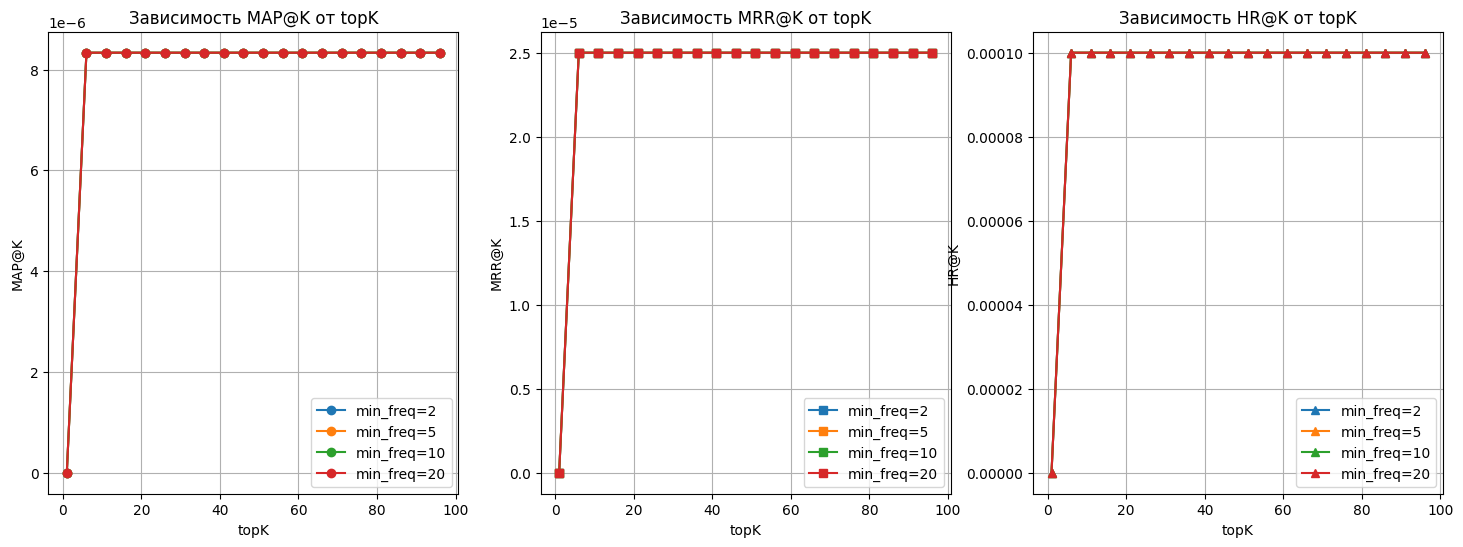

In [ ]:
# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for min_freq in min_freq_values:
    axes[0].plot(topk_values, metrics_results_topk[min_freq]["map"], marker="o", label=f"min_freq={min_freq}")
    axes[1].plot(topk_values, metrics_results_topk[min_freq]["mrr"], marker="s", label=f"min_freq={min_freq}")
    axes[2].plot(topk_values, metrics_results_topk[min_freq]["hr"], marker="^", label=f"min_freq={min_freq}")

axes[0].set_xlabel("topK")
axes[0].set_ylabel("MAP@K")
axes[0].set_title("Зависимость MAP@K от topK")
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel("topK")
axes[1].set_ylabel("MRR@K")
axes[1].set_title("Зависимость MRR@K от topK")
axes[1].legend()
axes[1].grid(True)

axes[2].set_xlabel("topK")
axes[2].set_ylabel("HR@K")
axes[2].set_title("Зависимость HR@K от topK")
axes[2].legend()
axes[2].grid(True)

plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

1. **Графики практически не различаются для разных min_freq** – это означает, что фильтрация по минимальной частоте встречаемости пользователей и айтемов не сильно влияет на метрики
   
2. **Резкий скачок при k=1 и затем стабилизация** – на всех графиках видно, что при увеличении `topK` метрики быстро достигают своего предела и перестают меняться. Это говорит о том, что увеличение количества рекомендаций после определенного `k` не дает дополнительного прироста качества

3. **Очень низкие значения метрик** – если метрики находятся на уровне `1e-6`, `1e-5`, `1e-4`, это указывает на плохую способность модели к предсказанию релевантных айтемов

4. **MAP@K, MRR@K и HR@K ведут себя одинаково** – это ожидаемо, поскольку все три метрики оценивают попадание релевантных рекомендаций в топ-K, но с разными подходами

5. **Графики соответствуют ожиданиям** – модели рекомендаций обычно показывают экспоненциальное поведение: резкое увеличение на малых `topK`, после чего метрики выходят на плато. Это поведение наблюдается и здесь

Вывод:
- Модель, вероятно, не работает достаточно хорошо для данного набора данных, либо требует лучшего подбора гиперпараметров
- Возможно, стоит пересмотреть способ предобработки данных или попробовать другую модель, например, гибридную с учетом пользовательских предпочтений


**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [ ]:
import numpy as np
import random
import pandas as pd

def get_item2item_recs(ease_weights, item2id, id2item, items_df, topn=5):
    """
    Получение item2item рекомендаций из матрицы весов EASE.

    ease_weights - матрица весов модели EASE
    item2id - словарь маппинга item_id -> индекс в матрице
    id2item - словарь маппинга индекс -> item_id
    items_df - DataFrame с названиями фильмов
    topn - количество топ рекомендаций для каждого айтема
    """
    item_ids = list(item2id.keys())
    sampled_items = random.sample(item_ids, 10)  # Выбираем 10 случайных айтемов

    recs = {}

    for item in sampled_items:
        item_index = item2id[item]
        scores = ease_weights[item_index]  # Получаем строку весов для айтема
        top_indices = np.argsort(-scores)[:topn + 1]  # Берем topN + сам айтем

        recommended_items = [id2item[idx] for idx in top_indices if idx != item_index][:topn]  # Убираем сам айтем

        recs[items_df.loc[items_df.item_id == item, "title"].values[0]] = [
            items_df.loc[items_df.item_id == rec_id, "title"].values[0] for rec_id in recommended_items
        ]

    return recs

# Загружаем матрицу весов
ease_weights = joblib.load("ease_weights.pkl")

# Получение item2item рекомендаций
item2item_recs = get_item2item_recs(ease_weights, item2id, id2item, items)

# Вывод топ-10 примеров
for movie, recommendations in item2item_recs.items():
    print(f"Фильм: {movie}")
    print("Рекомендованные фильмы:", ", ".join(recommendations))
    print("-" * 80)

Фильм: Путешествие времени
Рекомендованные фильмы: Явление, Разлом, Однажды в лесу, Откровения пирамид, Во власти стихии
--------------------------------------------------------------------------------
Фильм: Новогодний брак
Рекомендованные фильмы: Новогодний ремонт, В Россию за любовью, Новогодний переполох, Смотри как я, Москва, я терплю тебя
--------------------------------------------------------------------------------
Фильм: Ой, мамочки
Рекомендованные фильмы: Любовный менеджмент, Статус: Обновлён, Сдается жилье, Любовь без пересадок, Любовь не по размеру
--------------------------------------------------------------------------------
Фильм: Идеальная пара
Рекомендованные фильмы: Свадебные хлопоты, Я его слепила, В ожидании весны, Некрасивая подружка, Костёр на снегу
--------------------------------------------------------------------------------
Фильм: Будущее
Рекомендованные фильмы: Не все дома, Прощай, СССР, Жаным, ты не поверишь, Играй со мной, Выбивая долги
-----------------

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

Ответ:

**Хорошие рекомендации:**  
- "Мадагаскар 2" → "Мадагаскар 3", "Пингвины Мадагаскара" (одна франшиза).
- "Дрожь земли 5" → "Дрожь земли", "Анаконда 4" (схожий жанр)  
- "Предложение (2009)" → "Шопоголик", "Красотка" (ромкомы)  

**Средние:**  
- "Путешествие времени" → документальные и природные фильмы
- "Гонка века" → фильмы про борьбу и выживание

**Плохие:**  
- "Будущее" → разнородные фильмы без четкой связи
- "Годы" → случайные рекомендации  

**Причины плохих примеров:**  
1. Недостаток данных  
2. Превалирование популярности над смысловой связью  
3. Жанровая неоднозначность
4. Ошибки в построении матрицы взаимодействий

**Вывод:**  
Рекомендации в целом неплохие, но требуют улучшения через фильтрацию жанров и добавление контекста
